# Experiments with Trustchain Data

In [2]:
%matplotlib inline
import csv
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import collections
import numpy as np
import ast
import pandas as pd
import io

### Fetch transactions and peer confirmations

In [3]:
tx_store = {}
inverted_seen = {}
# Read trustchain transactions
with open("Datasets/leader_blocks_time_agg_1000_15.csv") as read_file:
    first = True
    csv_reader = csv.reader(read_file)
    first = True
    for row in csv_reader:
        if first:
            first = False
        else:
            # time, transaction, seq_num, link, seen_by 
            time = float(row[0])
            tx = ast.literal_eval(row[1])
            seq_num = int(row[2])
            link = int(row[3])
            seen_by = int(row[4])
            
            if seen_by not in inverted_seen.keys():
                inverted_seen[seen_by] = set()
                
            tx_id = str(tx['from_peer'])+"_"+str(seq_num)
            if tx_id not in tx_store.keys():
                tx_store[tx_id] = {"tx":tx, "seen": set(), "seen_confirm": set()}
            if link != 0:
                # This is confirmation for the transaction
                tx_id = str(tx['from_peer'])+"_"+str(link)
                try:
                    tx_store[tx_id]["seen_confirm"].add(seen_by)
                except KeyError as e:
                    tx_store[tx_id] = {"tx":tx, "seen": set(), "seen_confirm": {seen_by}}
                    
                tx_store[tx_id]["tx"]["seq"] = link
                tx_store[tx_id]["tx"]["link"] = seq_num
                # Send 
                tx_id_inv = str(tx['to_peer']) + "_" + str(seq_num)
                tx_store[tx_id_inv] = tx_store[tx_id]
                inverted_seen[seen_by].add(tx_id)
                inverted_seen[seen_by].add(tx_id_inv)
            else:
                tx_store[tx_id]["tx"]["seq"] = seq_num
                tx_store[tx_id]["seen"].add(seen_by)
                inverted_seen[seen_by].add(tx_id)


In [52]:
def compress_blocks(blocks):
    """
    Compress blocks -> is a seqencing algorithm in a nutshell 
    """
    array = [0 for _ in range(200)]
    for b in blocks:
        for i in range (b[0], b[1]+1):
            array[i] = 1
    new_blocks = []
    last_open = 0
    opened_block = False
    last_closed = 0
    for k in range(200):
        if array[k] == 1:
            if not opened_block:
                opened_block = True
                last_open = k
            last_closed = k 
        else:
            if opened_block:
                opened_block = False
                new_blocks.append((last_open, last_closed))
    return new_blocks, array

def find_last_sig_bit(mask):
    """
    Used to find holes
    """
    index = len(mask)-1
    while not mask[index]:
        index -= 1
    return index

def create_world_knowledge(peer_id, tx_store, inverted_seen):
    # all transactions seen by 
    peer_knows_peer = {}

    for tx in sorted(inverted_seen[peer_id], key=lambda tx_id: int(tx_id.split('_')[1])):
        #if int(tx.split('_')[0]) == peer_id:
        #    continue 
        # to peer knows about the from_peer
        # This is confirmation block 
        f_peer  = int(tx_store[tx]['tx']['from_peer'])
        t_peer = int(tx_store[tx]['tx']['to_peer'])
        
        if f_peer not in peer_knows_peer.keys():
            peer_knows_peer[f_peer] = {}
        if t_peer not in peer_knows_peer.keys():
            peer_knows_peer[t_peer] = {}
        
        if 'link' not in tx_store[tx]['tx'].keys():
            # The transaction was never confirmed by counterparty - potentially not seen! 
            continue

        if tx_store[tx]['tx']['link'] == int(tx.split('_')[1]):
            # We see confirmation transaction from the counterparty 
            # Update our knowledge 


            if t_peer not in peer_knows_peer[f_peer].keys():
                peer_knows_peer[f_peer][t_peer] = set()
            
            # F Peer was verified by T Peer up to SEQ num
            peer_knows_peer[f_peer][t_peer].add(tx_store[tx]['tx']["seq"])
        
        if f_peer not in peer_knows_peer[t_peer].keys():
                peer_knows_peer[t_peer][f_peer] = set()
        # T peer was verified by F Peer upto link block        
        peer_knows_peer[t_peer][f_peer].add(tx_store[tx]['tx']["link"])
    return peer_knows_peer
            

In [69]:
# Analyse the world from the perspective of peer wv
wv_peer  = 950 
# The peer who needs to be analysed 
target_peer = 1
# Validation window
window = 5

peer_knows_peer = create_world_knowledge(wv_peer, tx_store, inverted_seen)


if target_peer not in peer_knows_peer.keys():
    print("Peer is unknown")
else:
    peers_labels = peer_knows_peer[target_peer].keys()
    peers_num =  len(peer_knows_peer[target_peer].keys())

    inp = ""
    full_mask = [0 for _ in range(200)]

    for p in peers_labels:
        blocks = [(max(k-window, 1),k) for k in peer_knows_peer[target_peer][p]]
        new_blocks, array_mask = compress_blocks(blocks)
        full_mask = np.logical_or(full_mask, array_mask)
        for b in new_blocks:
            inp = inp + str(p) + str(",") + str(b[0])+str(",")+str(b[1])+str(",")+str("In") + "\n"

    last_index = find_last_sig_bit(full_mask)
    full_mask = full_mask[:last_index]
    holes = np.where(full_mask == False)[0][1:]
    number_of_holes = len(holes)

    print("Number of block holes in our world view "+ str(number_of_holes))
    print("Last known block "+str(last_index))
    if number_of_holes > 0:
        print("Holes: ")
        print(holes)


Number of block holes in our world view 6
Last known block 56
Holes: 
[14 15 22 23 24 25]


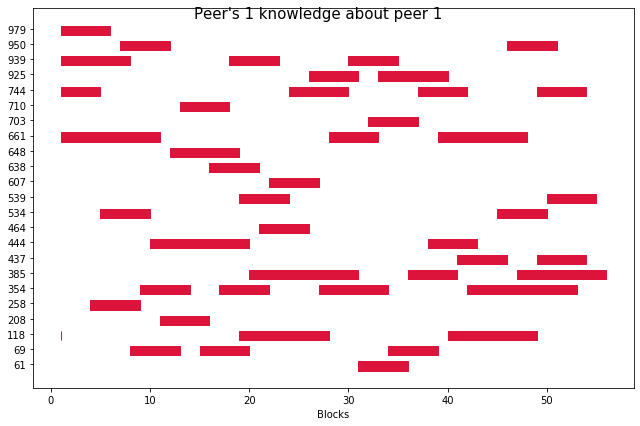

In [62]:
df = pd.read_csv(io.StringIO(inp), header=None, names=["Task", "Start", "Finish", "Resource"] )
df["Diff"] = df.Finish - df.Start

color = {"In":"crimson", "Out":"crimson"}
fig,ax=plt.subplots(figsize=(9,6))

fig.suptitle("Peer's %s knowledge about peer %s "%(wv_peer, target_peer), fontsize=15)
labels=[]
for i, task in enumerate(df.groupby("Task")):
    labels.append(task[0])
    for r in task[1].groupby("Resource"):
        data = r[1][["Start", "Diff"]]
        ax.broken_barh(data.values, (i-0.4,0.6), color=color[r[0]] )

ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels) 
ax.set_xlabel("Blocks")
plt.tight_layout()       
plt.show()

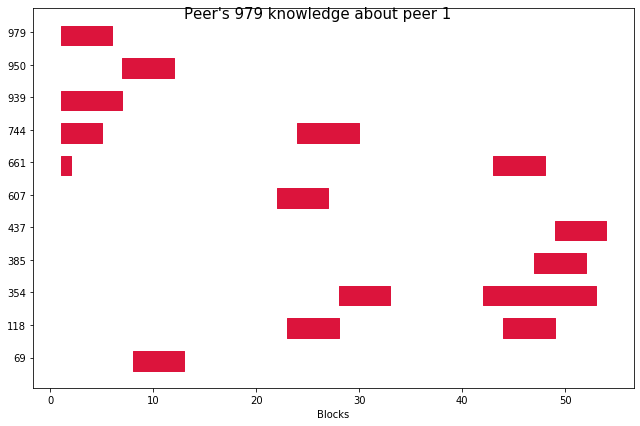

In [68]:
df = pd.read_csv(io.StringIO(inp), header=None, names=["Task", "Start", "Finish", "Resource"] )
df["Diff"] = df.Finish - df.Start

color = {"In":"crimson", "Out":"crimson"}
fig,ax=plt.subplots(figsize=(9,6))

fig.suptitle("Peer's %s knowledge about peer %s "%(wv_peer, target_peer), fontsize=15)
labels=[]
for i, task in enumerate(df.groupby("Task")):
    labels.append(task[0])
    for r in task[1].groupby("Resource"):
        data = r[1][["Start", "Diff"]]
        ax.broken_barh(data.values, (i-0.4,0.6), color=color[r[0]] )

ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels) 
ax.set_xlabel("Blocks")
plt.tight_layout()       
plt.show()

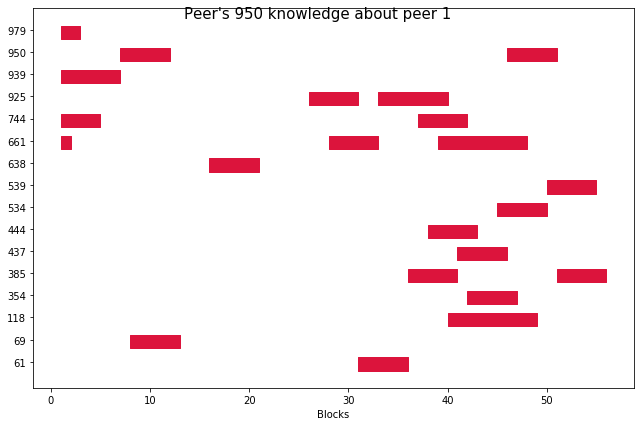

In [70]:
df = pd.read_csv(io.StringIO(inp), header=None, names=["Task", "Start", "Finish", "Resource"] )
df["Diff"] = df.Finish - df.Start

color = {"In":"crimson", "Out":"crimson"}
fig,ax=plt.subplots(figsize=(9,6))

fig.suptitle("Peer's %s knowledge about peer %s "%(wv_peer, target_peer), fontsize=15)
labels=[]
for i, task in enumerate(df.groupby("Task")):
    labels.append(task[0])
    for r in task[1].groupby("Resource"):
        data = r[1][["Start", "Diff"]]
        ax.broken_barh(data.values, (i-0.4,0.6), color=color[r[0]] )

ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels) 
ax.set_xlabel("Blocks")
plt.tight_layout()       
plt.show()

## Peers interaction simulation

## Set-reconcilation with cuckoo filters

### One filter per account?

The performance of the filter will degrade with more values inserted. 
To improve performance we need to introduce moving window of the elements, or limit the number of transactions. 

Filter will be filled with transaction id/hash. 

Having a filter and a new transaction one can check quickly if the transacion is inserted in the right time. 
Bloom clock 



## Transaction 

Transaction is a state transaction of a Peer A from $T_k: s_k -> s_{k+1}$. 

State can be represented as a Bloom clock? Counting Bloom Filter or Cuckoo filter

Each peer has own clock, event happend can be computed -> $H_k(B)+=1$ for each $H_k$. This will update certain cells in the clock. 

Transactions with different peers can be executed concurrently and later merged. 
